# Задача 1

The database consists of the following tables:

create table dbo.customer (

customer_id int identity primary key clustered
, customer_name nvarchar(256) not null
)
create table dbo.purchase_order (
purchase_order_id int identity primary key clustered

, customer_id int not null
, amount money not null
, order_date date not null
)

Implement a SQL query for the report that will provide the following information: for each customer
output at most 5 different dates which contain abnormally high or low amounts, for each of these dates
output minimum and maximum amounts as well. It can be assumed that the data is normally
distributed.

Ok, let's generate some data to play with.

In [27]:
import datetime
from scipy.stats import norm
import pandas as pd
import numpy as np
np.random.seed(0)

In [28]:
ids = np.arange(0,1000)
amount = np.random.normal(loc=25000,scale=7000,size=1000)
dates = 4*[datetime.datetime.today().date() - 
           datetime.timedelta(days=x) 
           for x in range(0, 250)][::-1]
customer_ids = [np.random.choice([1,2,3]) for _ in range(1000)]

In [29]:
purchase_order = pd.DataFrame({'purchase_order_id':ids,
                               'customer_id':customer_ids,
                               'amount':amount,
                               'order_date':dates})
purchase_order.head()

,amount,customer_id,order_date,purchase_order_id
0,37348.366422,1,2015-09-06,0
1,27801.100459,3,2015-09-07,1
2,31851.165889,3,2015-09-08,2
3,40686.252394,3,2015-09-09,3
4,38072.905931,2,2015-09-10,4


In [46]:
customer = pd.DataFrame({'customer_id':[1,2,3,4],
              'customer_name':
              ['Bond, James','Snow, Jon','McCormick, Kenny','Julius']})
customer

,customer_id,customer_name
0,1,"Bond, James"
1,2,"Snow, Jon"
2,3,"McCormick, Kenny"
3,4,Julius


Now convert them to sql.

In [47]:
import sqlite3

In [48]:
conn = sqlite3.connect(":memory:")

In [49]:
customer.to_sql('customer',conn,index=False,if_exists='replace')
purchase_order.to_sql('purchase_order',conn,index=False,if_exists='replace')

We are ready to go. This task is definitely an outlier detection problem. I will use extreme z-score. Sqlite doesn't have standard deviation function (and doesn't have sqrt too), so I have to add it via python. I found this:

In [50]:
import math
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1

    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1

    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))

In [51]:
conn.create_aggregate("stdev", 1, StdevFunc)

In [52]:
cur = conn.cursor()

I will implement this query step by creating tables. Of course it possible to combine it into one crazy query, but why? In my opinion it is often better to create simple queries - they are more robust and easy to debug. I can optimize it later depending on platform and sql dialect.

So at first I will create table with standard deviations and mean for each customer.

In [74]:
table_name = 'test'

drop_statement = 'drop table {}'.format(table_name)

try:
    cur.execute(drop_statement)
except:
    pass
    
sql = """create table {} as
        select
            t1.customer_name
           
            
        from 
        customer t1
        left join 
        purchase_order t2 on (t1.customer_id = t2.customer_id)
        where
        t2.order_date between date('2015-09-06') and date('2015-09-07')

        group by t1.customer_name,t2.order_date
        
        order by sum(t2.amount) desc
        
        limit 1
        
""".format(table_name)

cur.execute(sql)
select_statement = 'select * from {}'.format(table_name)
cur.execute(select_statement)
pd.DataFrame(cur.fetchall())

,0
0,"Bond, James"


In [37]:
table_name = 'outliers1'

drop_statement = 'drop table {}'.format(table_name)

try:
    cur.execute(drop_statement)
except:
    pass
    
sql = """create table {} as
        select
            t1.customer_id as customer_id,
            avg(t1.amount) as avg,
            stdev(t1.amount) as std
        from 
        purchase_order t1
        group by t1.customer_id  
        
""".format(table_name)

cur.execute(sql)
select_statement = 'select * from {}'.format(table_name)
cur.execute(select_statement)
pd.DataFrame(cur.fetchall())

,0,1,2
0,1,24310.443234,7006.548927
1,2,25209.244841,6909.659161
2,3,24498.287095,6819.626783


Next I will calculate z-score for each customer and purchase_id.

In [12]:
table_name = 'outliers2'

drop_statement = 'drop table {}'.format(table_name)

try:
    cur.execute(drop_statement)
except:
    pass
    
sql = """create table {} as

        select
            t1.purchase_order_id as purchase_order_id,
            t1.customer_id as customer_id,
            t1.order_date as order_date,
            t1.amount as amount,
            (t1.amount - t2.avg)/t2.std as z_score
        from 
        purchase_order t1
        left join
        outliers1 t2 on (t1.customer_id = t2.customer_id)
 
""".format(table_name)

cur.execute(sql)
select_statement = 'select * from {}'.format(table_name)
cur.execute(select_statement)
pd.DataFrame(cur.fetchall()).head()

,0,1,2,3,4
0,0,1,2015-08-31,37348.366422,1.860820
1,1,3,2015-09-01,27801.100459,0.484310
2,2,3,2015-09-02,31851.165889,1.078194
3,3,3,2015-09-03,40686.252394,2.373732
4,4,2,2015-09-04,38072.905931,1.861693


Now let's group by date and customer, find min and max and also max (by abs) z-score.

In [13]:
table_name = 'outliers3'

drop_statement = 'drop table {}'.format(table_name)

try:
    cur.execute(drop_statement)
except:
    pass
    
sql = """create table {} as

        select
        
            t1.customer_id as customer_id,
            t1.order_date as order_date,
            min(t1.amount) as min_amount,
            max(t1.amount) as max_amount,
            max(abs(t1.z_score)) as abs_z_score
            
        from 
        outliers2 t1
        group by
        t1.customer_id,
        t1.order_date
        
        order by
        t1.customer_id,
        max(abs(t1.z_score)) desc
        
""".format(table_name)

cur.execute(sql)
select_statement = 'select * from {}'.format(table_name)
cur.execute(select_statement)
pd.DataFrame(cur.fetchall()).head()

,0,1,2,3,4
0,1,2015-11-28,3676.998616,32381.162089,2.944880
1,1,2016-03-11,12556.331317,44315.485798,2.855192
2,1,2016-01-26,15788.648126,43160.972114,2.690416
3,1,2016-02-24,5822.259830,32119.146940,2.638700
4,1,2015-09-20,7129.071289,7129.071289,2.452188


Now I will display top-5 dates for each customer and add customer_name.

In [14]:
table_name = 'outliers4'

drop_statement = 'drop table {}'.format(table_name)

try:
    cur.execute(drop_statement)
except:
    pass
    
sql = """create table {} as

        select
        
            t3.customer_name,
            t1.order_date as order_date,
            t1.min_amount,
            t1.max_amount,
            t1.abs_z_score,
            count(t2.customer_id) as rank
            
        from outliers3 t1
        left join
        outliers3 t2 on
        (t2.customer_id = t1.customer_id
        and t1.abs_z_score <= t2.abs_z_score)
        left join customer t3 on (t1.customer_id = t3.customer_id)
        
        group by 
        
            t3.customer_name,
            t1.abs_z_score
        
        having count(t2.customer_id) <= 5

        order by t1.customer_id, t1.abs_z_score desc
        
""".format(table_name)

cur.execute(sql)
select_statement = 'select * from {}'.format(table_name)
cur.execute(select_statement)
df = pd.DataFrame(cur.fetchall())
df.columns = ['customer_name','order_date','min_amount','max_amount','z_score_abs','rank']

Here it is:

In [15]:
df

,customer_name,order_date,min_amount,max_amount,z_score_abs,rank
0,"Bond, James",2015-11-28,3676.998616,32381.162089,2.944880,1
1,"Bond, James",2016-03-11,12556.331317,44315.485798,2.855192,2
2,"Bond, James",2016-01-26,15788.648126,43160.972114,2.690416,3
3,"Bond, James",2016-02-24,5822.259830,32119.146940,2.638700,4
4,"Bond, James",2015-09-20,7129.071289,7129.071289,2.452188,5
5,"Snow, Jon",2015-09-21,5591.850705,29575.330168,2.839126,1
6,"Snow, Jon",2016-04-22,6410.666349,6410.666349,2.720623,2
7,"Snow, Jon",2015-10-17,7085.707336,29080.675758,2.622928,3
8,"Snow, Jon",2016-04-21,16906.722977,42480.402741,2.499567,4
9,"Snow, Jon",2015-09-28,8412.891663,35729.454501,2.430851,5


It can be done a lot easier with pandas.

In [16]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

//anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [17]:
z_scores = purchase_order.groupby(['customer_id'])['amount'].apply(zscore,ddof=1)
z_scores1 = np.hstack([z_scores[1],z_scores[2],z_scores[3]])
purchase_order1 = purchase_order.sort_values(['customer_id','purchase_order_id'])
purchase_order1['z_score'] = z_scores1

I won't reproduce original report, let’s better look at visualization.

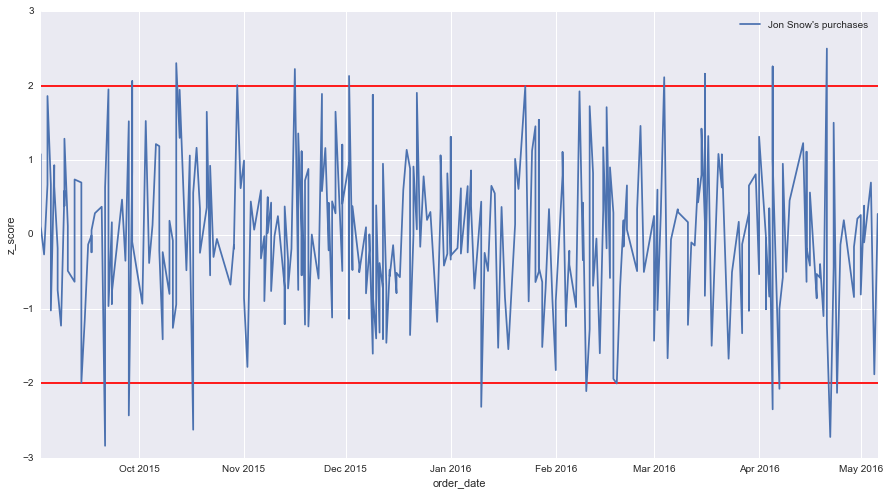

In [18]:
purchase_order1[purchase_order1['customer_id'] == 2].plot('order_date',
                                                          'z_score',
                                                          figsize=(15, 8),
                                                         label = "Jon Snow's purchases")
plt.hlines(2,
           purchase_order1['order_date'].min(),
          purchase_order1['order_date'].max(),
          color='r')
plt.hlines(-2,
           purchase_order1['order_date'].min(),
          purchase_order1['order_date'].max(),
          color='r')
plt.ylabel('z_score')

# Задача 2.

Необходимо проверить, что новый метод лечения пациентов приводит к успеху на 10% чаще по сравнению с традиционным. Для проведения испытаний набирается две группы: пилотная (на который применяется новый метод лечения) и контрольная (традиционный метод лечения) одинакового объёма. Каково минимальное количество пациентов для каждой группы, необходимое для заданных вероятности ошибки первого рода = 2,5% и мощности 80%

$H_0: p_2 - p_2 \neq 10\% $

$H_1: p_2 - p_2 = 10\% $

$\alpha = 0.025; 1 - \beta = 0.80; n - ?$

Согласно книге [Statistical Methods for Rates and Proportions, 3rd Edition](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471526290.html) (глава 4) размер необходимой выборки для двухстороннего теста и равных групп можно посчитать по формуле:

$ n = \frac{(Z_{\alpha/2}\sqrt{2\bar{P}\bar{Q}}+Z_{\beta}\sqrt{P_1Q_1+P_2Q_2})^2}{(P_2-P_1)^2} $

In [19]:
def get_sample_size(p1,p2,alpha=0.025,power=0.8):
    
    p_bar = (p1 + p2)/2
    q_bar = 1 - p_bar
    
    v1 = p1 * (1 - p1) # P*Q
    v2 = p2 * (1 - p2)
    
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    
    n = ((z_alpha * np.sqrt(2 * p_bar * q_bar) +
        z_beta * np.sqrt(v1 + v2))**2/
        ((p2 - p1)**2))
    
    return n

Проверим например для p1=0.5 и p2=0.6

In [20]:
get_sample_size(0.5,0.6)

469.1995557331303

Сравним с имплементацией в scipy

In [21]:
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.5, 0.6)
sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.025, ratio=1)

468.86337425839423

Очень близко. Видимо у них как-то по другому сделано - возможно они используют какую-то другую аппроксимацию вместо нормальной. В условии задачи сказано найти минимальное кол-во пациентов в каждой группе. Поскольку мы ничего не знаем о возможной доле, то я построю таблицу для всех возможных.

In [22]:
proportions = [0.01, 0.05, 0.1, 0.2, 
               0.3, 0.4, 0.5, 0.6,
               0.7, 0.8, 0.9, 1]

l = len(proportions)

In [23]:
sample_sizes = np.zeros((l,l))

In [24]:
for i, p1 in enumerate(proportions):
    for j, p2 in enumerate(proportions):
        try:
            sample_sizes[i][j] = int(round(get_sample_size(p1,p2)))
        except:
            sample_sizes[i][j] = get_sample_size(p1,p2)

In [25]:
df = pd.DataFrame(sample_sizes,index=proportions,columns=proportions)

In [26]:
df = df.replace(np.inf,0).fillna(0).astype(int).replace(0,np.nan)
df

,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.01,NaN,344.0,121.0,48.0,28.0,19.0,14.0,10.0,8.0,6.0,4.0,3.0
0.05,344.0,NaN,526.0,91.0,43.0,26.0,17.0,12.0,9.0,7.0,5.0,3.0
0.10,121.0,526.0,NaN,241.0,75.0,38.0,24.0,16.0,11.0,8.0,6.0,4.0
0.20,48.0,91.0,241.0,NaN,355.0,98.0,47.0,27.0,17.0,12.0,8.0,6.0
0.30,28.0,43.0,75.0,355.0,NaN,431.0,113.0,51.0,28.0,17.0,11.0,7.0
0.40,19.0,26.0,38.0,98.0,431.0,NaN,469.0,118.0,51.0,27.0,16.0,10.0
0.50,14.0,17.0,24.0,47.0,113.0,469.0,NaN,469.0,113.0,47.0,24.0,13.0
0.60,10.0,12.0,16.0,27.0,51.0,118.0,469.0,NaN,431.0,98.0,38.0,18.0
0.70,8.0,9.0,11.0,17.0,28.0,51.0,113.0,431.0,NaN,355.0,75.0,26.0
0.80,6.0,7.0,8.0,12.0,17.0,27.0,47.0,98.0,355.0,NaN,241.0,41.0


Руководствуясь это таблицей можно выбирать размер каждой группы в зависимости от исходной доли.